In [1]:
import pandas as pd
import numpy as np
import time
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [2]:
# datapath corresponnds to the path where the dataset is stored, 
# please go to the very first cell at the top and download the dataset and provide path to the stored location
datapath = "D:/Datasets/fifa19"
os.chdir(datapath)

In [3]:
df = pd.read_csv("data.csv")

In [4]:
columns_to_drop = ["Unnamed: 0", "ID", "Photo", "Flag", "Club Logo", 'LS', 'ST',
       'RS', 'LW', 'LF', 'CF', 'RF', 'RW', 'LAM', 'CAM', 'RAM', 'LM', 'LCM',
       'CM', 'RCM', 'RM', 'LWB', 'LDM', 'CDM', 'RDM', 'RWB', 'LB', 'LCB', 'CB',
       'RCB', 'RB', "Loaned From", 'Real Face']

df.drop(columns=columns_to_drop, inplace = True)

In [5]:
# Out of all players some players have some attributes not known as in the nan_players
nan_plyers = df[df.isnull().any(1)]

In [6]:
df.dropna(inplace = True)
df.reset_index(drop = True, inplace = True)

In [7]:
df.shape

(16643, 56)

In [8]:
# seggregating the attribute columns into different categories for easier handling

identity_features = ['Name', 'Nationality', 'Age', 'Club', 'Preferred Foot',
                     'Work Rate', 'Position', 'Joined',
                     'Contract Valid Until', 'Height', 'Weight']

money_features = ['Value', 'Wage', 'Release Clause']

attribute_features = ['Overall', 'Potential', 'Special', 'International Reputation',
       'Weak Foot', 'Skill Moves', 'Jersey Number', 'Crossing', 'Finishing',
       'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling', 'Curve',
       'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration',
       'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower',
       'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression',
       'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure',
       'Marking', 'StandingTackle', 'SlidingTackle', 'GKDiving', 'GKHandling',
       'GKKicking', 'GKPositioning', 'GKReflexes']

general_columns = ['Name', 'Nationality', 'Age', 'Club', 'Preferred Foot',
                   'Work Rate', 'Position', 'Joined',
                   'Contract Valid Until', 'Height', 'Weight', 
                   'International Reputation','Jersey Number',]

In [9]:
first = df[identity_features]
second = df[money_features]
third = df[attribute_features]
general = df[general_columns]

In [10]:
def joined_year(rows):
    if len(rows["Joined"].split(",")) == 2:
        return rows["Joined"].split(",")[1]
    else:
        return np.nan

first["Joined Year"] = first.apply(joined_year, axis = "columns")
first["Contract Valid Until"] = first["Contract Valid Until"].astype(int)
first["Joined Year"] = first["Joined Year"].astype(int)
first["Years in Contract"] = first["Contract Valid Until"] - first["Joined Year"]

In [11]:
def convert_height(rows):
    """
    Converting the height which is in feet, inches to centimeter.
    1 feet = 30.48 centimeter
    1 inch = 2.54 centimeter
    """
    if len(rows["Height"].split("'")) == 2:
        return int(rows["Height"].split("'")[0]) * 30.48 + int(rows["Height"].split("'")[1]) * 2.54
    else:
        return np.nan

first["Height(cm)"] = first.apply(convert_height, axis = "columns")

In [12]:
def convert_weight(rows):
    """
    Converting the weight which is in pounds to Kgs.
    1 pound = 0.453592 kgs
    """
    if not pd.isnull(rows["Weight"]):
        return int(re.findall("[\d]+", rows["Weight"])[0]) * 0.453592
    else:
        return np.nan

first["Weight(kg)"] = first.apply(convert_weight, axis = "columns")

In [13]:
def convert_currency(rows):
    if rows[-1] == "M":
        return float(rows[1:-1])
    elif rows[-1] == "K":
        return float(rows[1:-1]) / 1000000
    else:
        return np.nan

second["Value(Million)"] = second["Value"].apply(convert_currency)
second["Wage(Million)"] = second["Wage"].apply(convert_currency)
second["Release Clause(Million)"] = second["Release Clause"].apply(convert_currency)

In [14]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import scale
second_columns = ["Value(Million)", "Wage(Million)", "Release Clause(Million)"]

#scaler = scale(axis = 0)
#scaled_second = scaler.fit_transform(second[second_columns])
scaled_second = scale(second[second_columns], axis= 0)
scaled_second = pd.DataFrame(scaled_second, columns = second_columns)

In [15]:
not_select = ["International Reputation", "Weak Foot", "Skill Moves", "Jersey Number"]
cols = [c for c in third.columns.values if c not in not_select]

#scaler = scale(axis = 0)
#scaled_third = pd.DataFrame(scaler.fit_transform(third[cols]), columns = cols)
scaled_third = scale(third[cols], axis = 0)
scaled_third = pd.DataFrame(scaled_third, columns = cols)

In [27]:
general_money = pd.concat([df[general_columns], second], axis = "columns")
quality_money = pd.concat([scaled_third, scaled_second], axis = "columns")
general_quality = pd.concat([df[general_columns], third], axis = "columns")

In [28]:
df.head()

,Name,Age,Nationality,Overall,Potential,Club,Value,Wage,Special,Preferred Foot,...,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause
0,L. Messi,31,Argentina,94,94,FC Barcelona,€110.5M,€565K,2202,Left,...,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,€226.5M
1,Cristiano Ronaldo,33,Portugal,94,94,Juventus,€77M,€405K,2228,Right,...,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,€127.1M
2,Neymar Jr,26,Brazil,92,93,Paris Saint-Germain,€118.5M,€290K,2143,Right,...,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,€228.1M
3,De Gea,27,Spain,91,93,Manchester United,€72M,€260K,1471,Right,...,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,€138.6M
4,K. De Bruyne,27,Belgium,91,92,Manchester City,€102M,€355K,2281,Right,...,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0,€196.4M


In [29]:
print("Total no of unique Countries : ", len(np.unique(df["Nationality"])))
print("Total no of unique Clubs : ", len(np.unique(df["Club"])))
print("Total no of unique Work Rate : ", len(np.unique(df["Work Rate"])))
print("Total no of unique Positions : ", len(np.unique(df["Position"])))

Total no of unique Countries :  161
Total no of unique Clubs :  651
Total no of unique Work Rate :  9
Total no of unique Positions :  27


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 <a list of 15 Text xticklabel objects>)

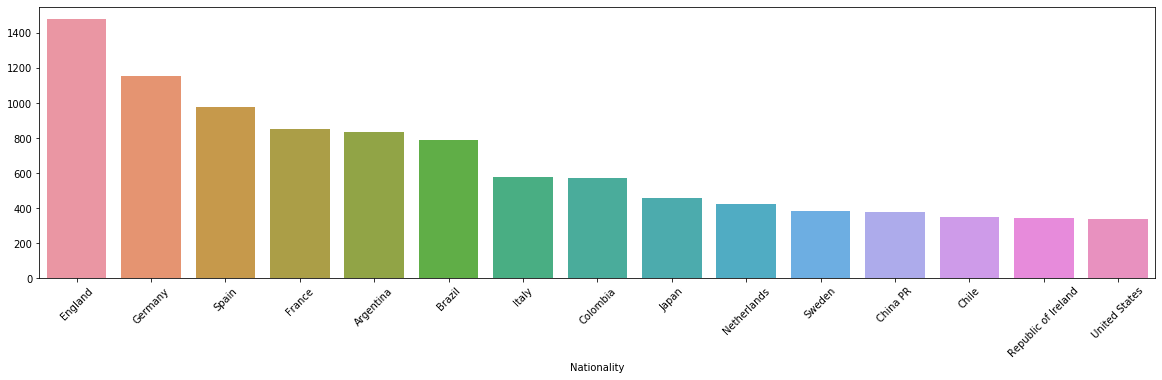

In [57]:
# Top 10 Nationalities based on their Player Counts
best = general.groupby(by = ["Nationality"]).aggregate("count")
best = best.sort_values(by = ["Name"], ascending = False).head(15)["Name"]
plt.figure(figsize = (20, 5))
sns.barplot(best.index, best.values)
plt.xticks(rotation = 45)
plt.show()

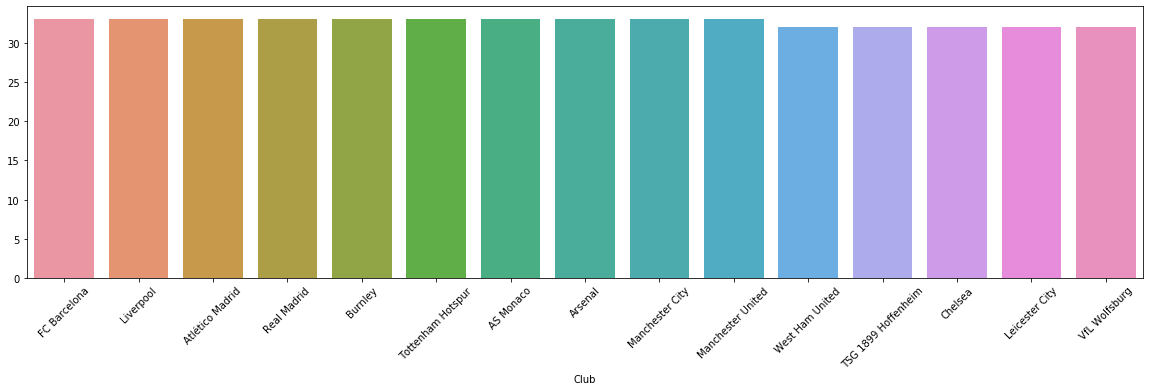

In [59]:
# Top 10 Clubs based on their Player Counts
best = general.groupby(by = ["Club"]).aggregate("count")
best = best.sort_values(by = ["Name"], ascending = False).head(15)["Name"]
plt.figure(figsize = (20, 5))
sns.barplot(best.index, best.values)
plt.xticks(rotation = 45)
plt.show()

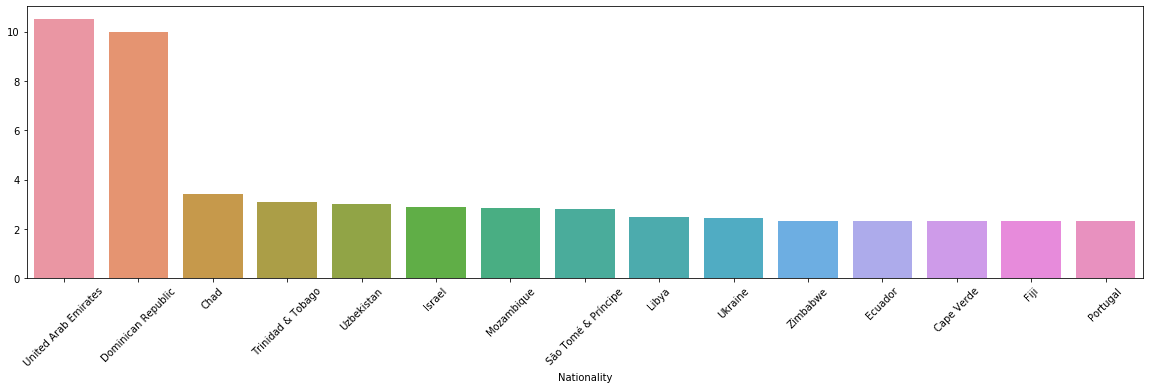

In [73]:
# Most Valued Countries based on their Players
best = general_money.groupby(by = ["Nationality"]).aggregate("median")
best = best.sort_values(by = ["Value(Million)"], ascending = False).head(15)["Value(Million)"]
plt.figure(figsize = (20, 5))
sns.barplot(best.index, best.values)
plt.xticks(rotation = 45)
plt.show()

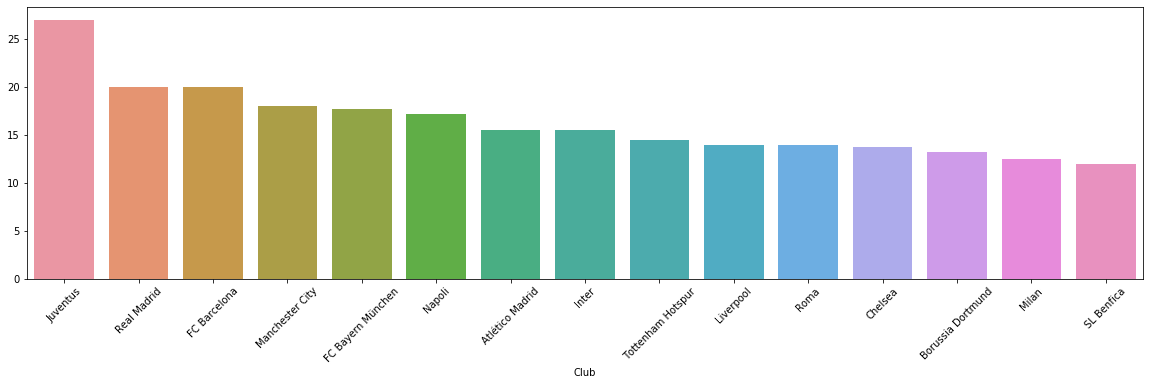

In [74]:
# Most Valued Countries based on their Players
best = general_money.groupby(by = ["Club"]).aggregate("median")
best = best.sort_values(by = ["Value(Million)"], ascending = False).head(15)["Value(Million)"]
plt.figure(figsize = (20, 5))
sns.barplot(best.index, best.values)
plt.xticks(rotation = 45)
plt.show()

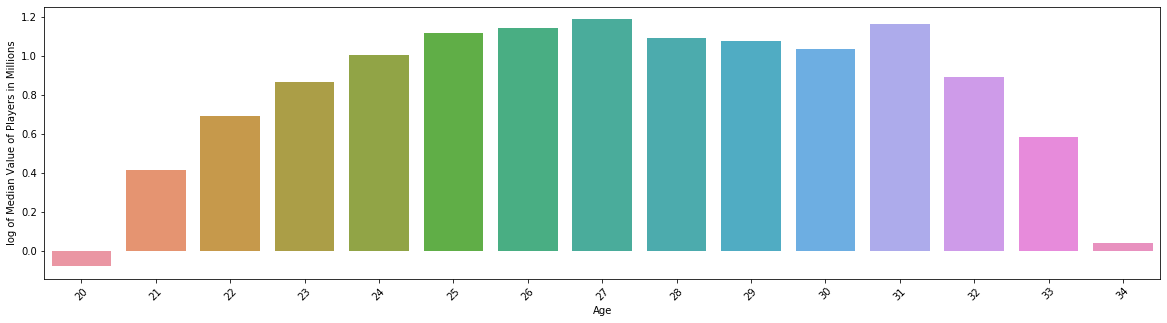

In [108]:
# values of Player based on their Age
best = general_money.groupby(by = ["Age"]).aggregate("mean")
best = best.sort_values(by = ["Value(Million)"], ascending = False).head(15)["Value(Million)"]
plt.figure(figsize = (20, 5))
sns.barplot(best.index, np.log(best.values))
plt.ylabel("log of Median Value of Players in Millions")
plt.xticks(rotation = 45)
plt.show()

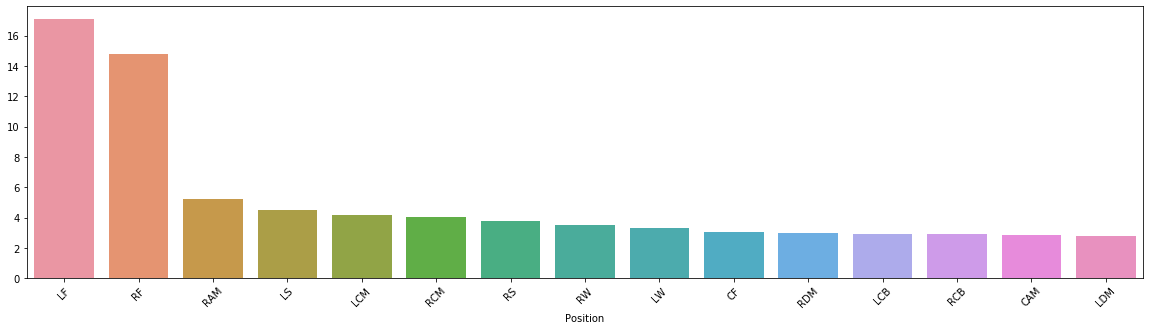

In [107]:
# Highest values players according to the position
best = general_money.groupby(by = ["Position"]).aggregate("mean")
best = best.sort_values(by = ["Value(Million)"], ascending = False).head(15)["Value(Million)"]
plt.figure(figsize = (20, 5))
sns.barplot(best.index, best.values)
plt.xticks(rotation = 45)
plt.show()

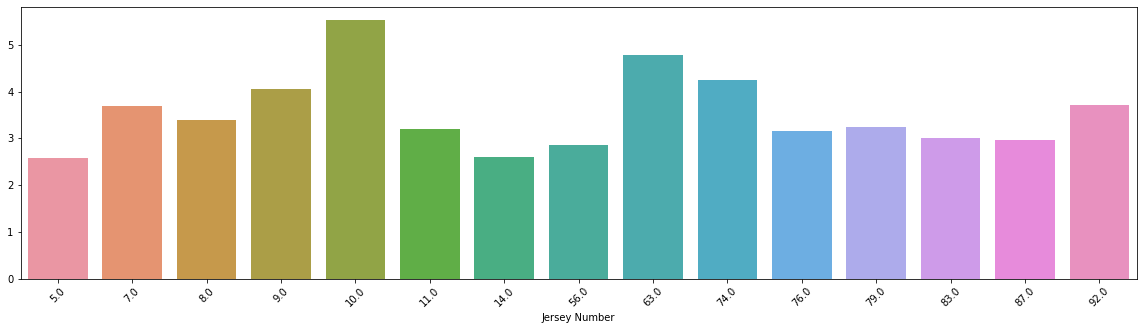

In [110]:
# Highest Valued Players according to Jersey Number
best = general_money.groupby(by = ["Jersey Number"]).aggregate("mean")
best = best.sort_values(by = ["Value(Million)"], ascending = False).head(15)["Value(Million)"]
plt.figure(figsize = (20, 5))
sns.barplot(best.index, best.values)
plt.xticks(rotation = 45)
plt.show()

In [180]:
# skills with respect to the Value
corr = quality_money.corr()
abs_corr = abs(corr)
abs_corr = abs_corr.sort_values(by = ["Value(Million)"], ascending = False)

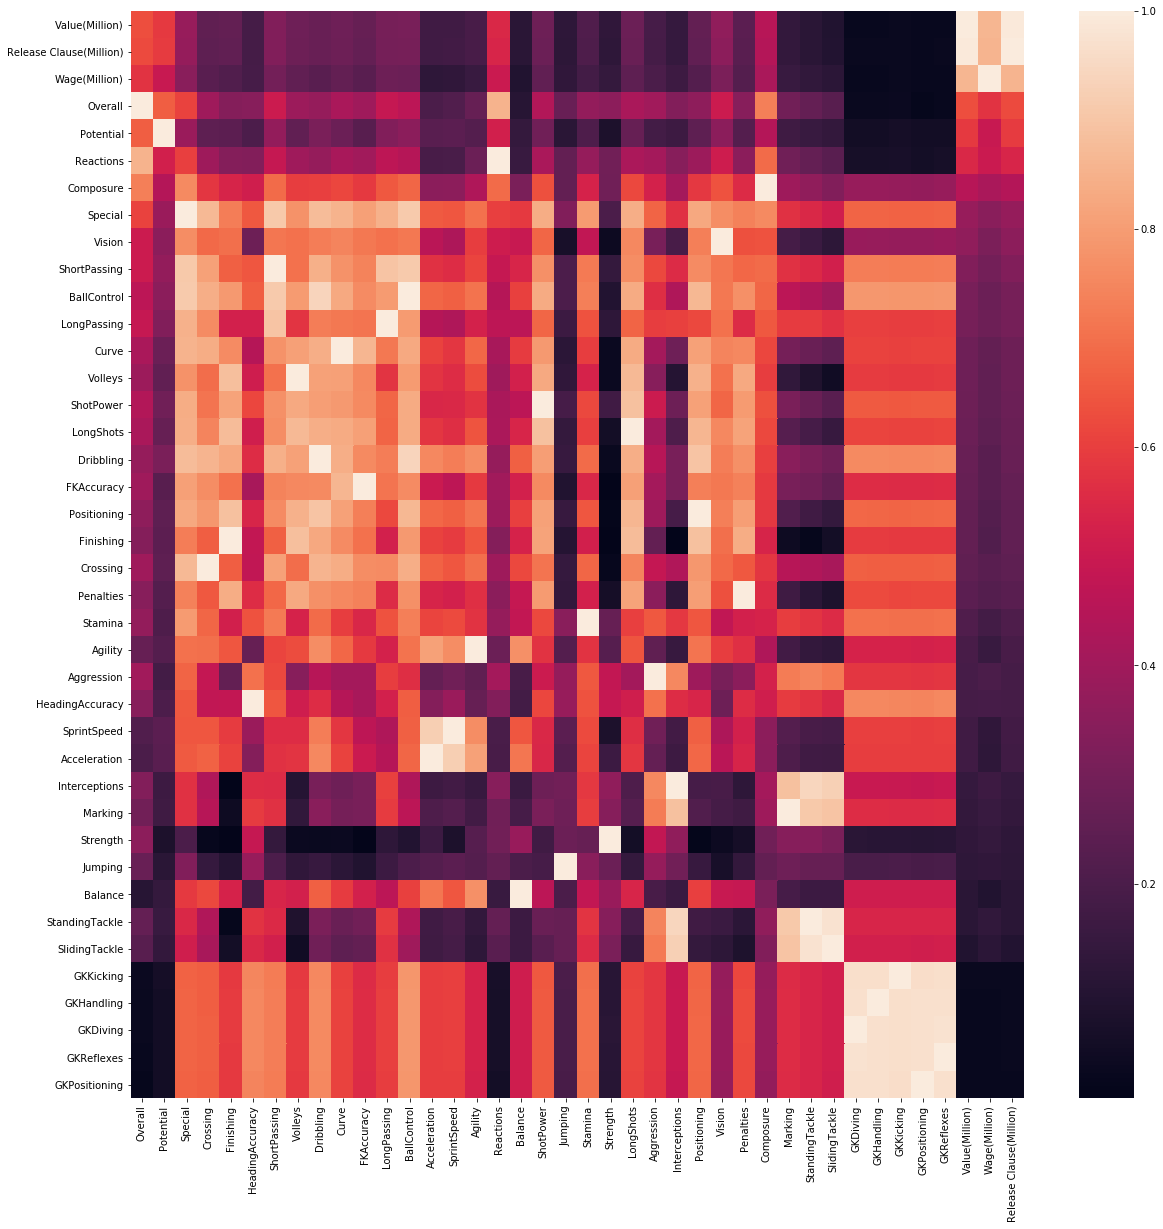

In [181]:
plt.figure(figsize = (20, 20))
sns.heatmap(abs_corr)
plt.show()

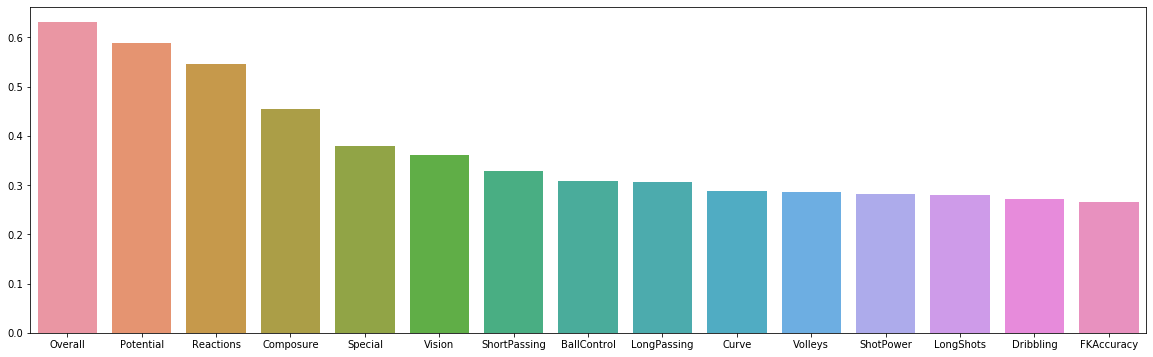

In [184]:
# Top 10 qualities which constitutes a Player Values is:
plt.figure(figsize = (20, 6))
sns.barplot(abs_corr.iloc[3:18,-3:-2].index, abs_corr.iloc[3:18,-3:-2].values.reshape(1, -1)[0])
plt.show()